In [1]:
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True

In [2]:
from spark_PCA import *
from row_parser import *

In [3]:
# %pylab inline

import pandas as pd
import datetime as dt

from scipy.io import loadmat, savemat, whosmat

from collections import Counter
import re
import numpy as np
from numpy import shape

from glob import glob
from time import time
import sys
from row_parser import *
from spark_PCA import *
from pyspark.sql import DataFrame

In [4]:
!ls -l ./../data/DSE230_version_Data/whale_data_15mb.np

-rw-r--r--  1 Jim  staff  15696962 Dec  6 22:32 ./../data/DSE230_version_Data/whale_data_15mb.np


In [5]:
file_path = './../data/DSE230_version_Data/whale_data_15mb.np'
file_data = np.load(file_path)

In [6]:
file_data

array([[datetime.datetime(2010, 8, 10, 11, 45, 36, 626459), u'Cuviers',
        u'DT', ..., 0, 0, 0],
       [datetime.datetime(2010, 8, 10, 11, 46, 6, 4604), u'Cuviers',
        u'DT', ..., 0, 0, 0],
       [datetime.datetime(2010, 8, 10, 12, 11, 25, 866437), u'Cuviers',
        u'DT', ..., 0, 0, 0],
       ...,
       [datetime.datetime(2013, 4, 30, 7, 19, 41, 228925), u'Gervais',
        u'MC', ..., 0, 0, 0],
       [datetime.datetime(2013, 5, 1, 11, 37, 0, 617731), u'Gervais',
        u'MC', ..., 0, 0, 0],
       [datetime.datetime(2013, 5, 1, 11, 38, 46, 580242), u'Gervais',
        u'MC', ..., 0, 0, 0]], dtype=object)

In [7]:
schema = {'time': np.datetime64,
           'species': 'object',
           'site': 'object',
           'rec_no': 'object',
           'bout_i': 'int64',
           'peak2peak': 'float64',
           'TPWS1': 'int64',
           'MD1': 'int64',
           'FD1': 'int64',
           'TPWS2': 'int64',
           'MD2': 'int64',
           'FD2': 'int64',
           'TPWS3': 'int64',
           'MD3': 'int64',
           'FD3': 'int64'}

In [8]:
from ast import literal_eval

def read_byte_arrays(bytearray_string):
    if bytearray_string.startswith('bytearray(') and \
            bytearray_string.endswith(')'):
        return bytearray(literal_eval(bytearray_string[10:-1]))
    return bytearray_string

In [9]:
df = pd.DataFrame(data=file_data, 
                  columns=['time', 'species', 'site', 'rec_no', 'bout_i', 'peak2peak', 'MSN', 'MSP', 'TPWS1', 'MD1', 'FD1', 'TPWS2', 'MD2', 'FD2', 'TPWS3', 'MD3', 'FD3'])

In [10]:
df = df.astype(dtype=schema)

In [11]:
df[:2]

,time,species,site,rec_no,bout_i,peak2peak,MSN,MSP,TPWS1,MD1,FD1,TPWS2,MD2,FD2,TPWS3,MD3,FD3
0,2010-08-10 11:45:36.626459,Cuviers,DT,01,5,50.2422,"[249, 15, 233, 183, 175, 163, 34, 64, 191, 125...","[209, 145, 92, 254, 67, 218, 66, 192, 164, 223...",1,0,0,1,0,0,0,0,0
1,2010-08-10 11:46:06.004604,Cuviers,DT,01,5,55.0377,"[241, 99, 204, 93, 75, 200, 1, 192, 155, 230, ...","[18, 20, 63, 198, 220, 93, 65, 192, 0, 0, 0, 0...",1,0,0,1,0,0,0,0,0


In [12]:
df.dtypes

time         datetime64[ns]
species              object
site                 object
rec_no               object
bout_i                int64
peak2peak           float64
MSN                  object
MSP                  object
TPWS1                 int64
MD1                   int64
FD1                   int64
TPWS2                 int64
MD2                   int64
FD2                   int64
TPWS3                 int64
MD3                   int64
FD3                   int64
dtype: object

In [13]:
df.groupby(['species']).count()

,time,site,rec_no,bout_i,peak2peak,MSN,MSP,TPWS1,MD1,FD1,TPWS2,MD2,FD2,TPWS3,MD3,FD3
species,,,,,,,,,,,,,,,,
Cuviers,2238,2238,2238,2238,2238,2238,2238,2238,2238,2238,2238,2238,2238,2238,2238,2238
Gervais,1937,1937,1937,1937,1937,1937,1937,1937,1937,1937,1937,1937,1937,1937,1937,1937


## Data PlayGround

### Data schema
The data was originally stored as Matlab files. Those were translated into csv file

#### The feature vector
Each click is defined by the following fields

|field name     | Description               | Data Type
|---------------|---------------------------|--------------
|0: time        | time of click             | string in datetime format `%Y-%m-%d %H:%M:%S.%f`
|2: site		| name of site		        | 'str'
|3: rec_no		| recording number		    | 'str'
|4: bout_i		| bout number		        | numpy.int64
|5: peak2peak	| peak to peak magnitude    | 			numpy.float64
|6: MSN	        |	wave form |		 an array of length 202
|208: MSP		|	spectra |	 an array of length 101

In [14]:
df[102:104]

,time,species,site,rec_no,bout_i,peak2peak,MSN,MSP,TPWS1,MD1,FD1,TPWS2,MD2,FD2,TPWS3,MD3,FD3
102,2010-10-17 18:40:45.590195,Cuviers,DT,01,158,68.6416,"[79, 175, 148, 101, 136, 227, 10, 64, 121, 88,...","[56, 103, 68, 105, 111, 200, 66, 192, 199, 186...",1,0,0,1,0,0,0,0,0
103,2010-10-18 04:23:15.413460,Cuviers,DT,01,160,48.5607,"[100, 93, 220, 70, 3, 120, 242, 63, 70, 182, 2...","[221, 36, 6, 129, 149, 251, 68, 192, 7, 95, 15...",1,0,0,1,0,0,0,0,0


In [15]:
def get_msn(row):
    """ extract MSN from row as numpy array"""
    return np.frombuffer(row.MSN)
def get_msp(row):
    """ extract MSP from row as numpy array"""
    return np.frombuffer(row.MSP)

In [16]:
import matplotlib.pyplot as plt

In [17]:
Gervais=df[df.species=='Gervais']
Cuviers=df[df.species=='Cuviers']

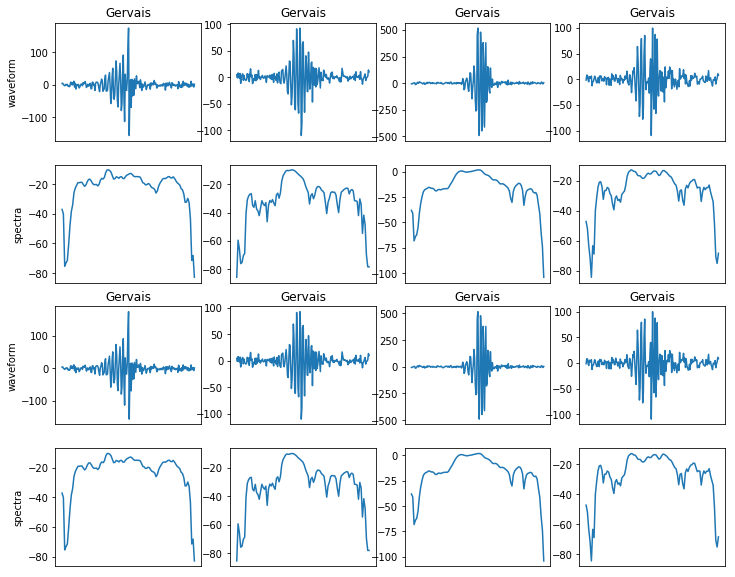

In [18]:
Gervais_4 = Gervais[:4]
Cuviers_4 = Cuviers[:4]

# After creating plot ...

#cur_axes = mplot.gca()
#cur_axes.axes.get_xaxis().set_ticks([])

plt.figure(figsize=(12,10))
i=0

for idx,row in (Gervais_4.append(Gervais_4)).iterrows():
    waveform=get_msn(row)
    spectra=get_msp(row)
    plt.subplot(4,4,i+1)
    plt.plot(waveform)
    plt.title(row.species)
    plt.gca().axes.get_xaxis().set_ticks([])
    if(i %4)==0:
        plt.ylabel('waveform')
    plt.subplot(4,4,i+5)
    plt.plot(spectra)
    plt.gca().axes.get_xaxis().set_ticks([])
    if(i %4)==0:
        plt.ylabel('spectra')

    i+=1
    if i==4:
        i=8
plt.show()

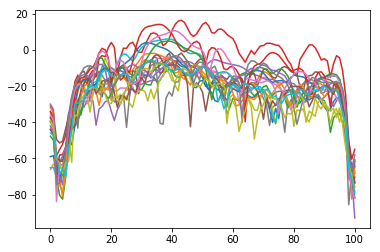

In [19]:
for index, row in df[:20].iterrows():
    spectra=get_msp(row)
    plt.plot(spectra)

In [20]:
df_MSP = pd.DataFrame(df.MSP.apply(lambda x: np.frombuffer(x)).values.tolist())

In [21]:
df_MSP.shape

(4175, 101)

In [22]:
cov = df_MSP.cov()
mean = df_MSP.mean()
var = np.sqrt(df_MSP.var())

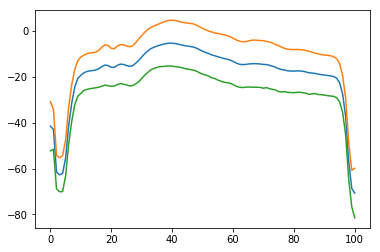

In [23]:
plt.plot(mean)
plt.plot(mean+var)
plt.plot(mean-var)